# RNN Models

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import keras_tuner as kt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import Embedding, Flatten, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, f1_score, 
                            confusion_matrix, roc_auc_score,
                            RocCurveDisplay)


## Model Variables

In [2]:
features = ['Open', 'High', 'Low', 'Volume']
target   = 'target'
rolling_window = 10 

## Data Pre-Processing

In [3]:
df = pd.read_csv("../filtered_stocks_combined.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date', 'ticker']).reset_index(drop=True)

df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['target']     = (df['Close'] > df['prev_close']).astype(int)
df = df.dropna(subset=['prev_close']).reset_index(drop=True)

## Dataset Split

In [4]:
# 2. Static 60/20/20 split
n_total  = len(df)
n_train  = int(0.6 * n_total)
n_val    = int(0.2 * n_total)

train_df = df.iloc[:n_train]
val_df   = df.iloc[n_train:n_train+n_val]
test_df  = df.iloc[n_train+n_val:].reset_index(drop=True)

## Feature Extraction & Scaling

In [5]:
scaler       = StandardScaler().fit(train_df[features])
X_train_s    = scaler.transform(train_df[features])
X_val_s      = scaler.transform(val_df[features])
y_train_arr  = train_df['target'].values
y_val_arr    = val_df['target'].values

## Create RNN Sequences

In [6]:
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_arr, rolling_window)
X_val_seq,   y_val_seq   = create_sequences(X_val_s,   y_val_arr,   rolling_window)

print("Train seq:", X_train_seq.shape, y_train_seq.shape)
print("Val   seq:", X_val_seq.shape,   y_val_seq.shape)

Train seq: (45260, 10, 4) (45260,)
Val   seq: (15080, 10, 4) (15080,)


## Base RNN Model
With untuned test parameters to check if model is working.

In [7]:
n_features = X_train_seq.shape[2]
model = Sequential([
    SimpleRNN(64, input_shape=(rolling_window, n_features)),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy'],
)
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1415/1415 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5048 - loss: 0.7047 - val_accuracy: 0.5125 - val_loss: 0.6931
Epoch 2/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5086 - loss: 0.6952 - val_accuracy: 0.5052 - val_loss: 0.6935
Epoch 3/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5114 - loss: 0.6938 - val_accuracy: 0.5141 - val_loss: 0.6932
Epoch 4/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5144 - loss: 0.6927 - val_accuracy: 0.5126 - val_loss: 0.6932
Epoch 5/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5161 - loss: 0.6929 - val_accuracy: 0.5161 - val_loss: 0.6936
Epoch 6/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5161 - loss: 0.6927 - val_accuracy: 0.5123 - val_loss: 0.6927
Epoch 7/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5144 - loss: 0.6928 - val_accuracy: 0.5153 - val_loss: 0.6926
Epoch 8/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5162 - loss: 0.6927 - val_accurac

### Running RNN on test data
RNN Model is run on rolling window test set from each year.

In [8]:
test_df['Year']     = test_df['Date'].dt.year
unique_years       = sorted(test_df['Year'].unique())
all_y_true, all_y_pred, all_y_proba = [], [], []
all_test_dates = []

for year in unique_years:
    year_test = test_df[test_df['Year']==year].reset_index(drop=True)
    Xt_s, yt_arr = (
        scaler.transform(year_test[features]),
        year_test['target'].values
    )
    Xt_seq, yt_seq = create_sequences(Xt_s, yt_arr, rolling_window)
    if Xt_seq.size == 0:
        continue

    proba = model.predict(Xt_seq).ravel()
    pred  = (proba > 0.5).astype(int)

    all_y_true.extend(yt_seq.tolist())
    all_y_pred.extend(pred.tolist())
    all_y_proba.extend(proba.tolist())
    all_test_dates.extend(year_test['Date'].iloc[rolling_window:].tolist())

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


### Evaluation


Rolling‑Window RNN Results:
Accuracy: 0.5161
F1 Score:  0.6670
AUC‑ROC:   0.5101

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down             472          6806
Actual Up               487          7305


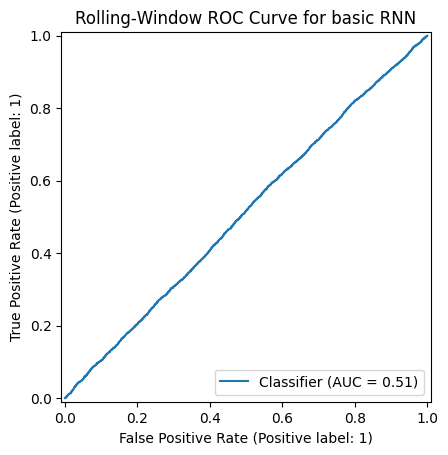

In [9]:
acc = accuracy_score(all_y_true, all_y_pred)
f1       = f1_score(all_y_true, all_y_pred)
auc      = roc_auc_score(all_y_true, all_y_proba)
cm       = confusion_matrix(all_y_true, all_y_pred)

print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('Rolling‑Window ROC Curve for basic RNN')
plt.show()

## Best RNN Model
Single layer basic RNN, with optimal parameters determined by a random search autotuner.

In [10]:
def build_rnn_model(hp):
    model = Sequential([
        SimpleRNN(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            input_shape=(rolling_window, len(features))
        ),
        Dropout(hp.Float('dropout', 0.0, 0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

class BacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = build_rnn_model(hp)
        year_accs = []

        for idx, year in enumerate(unique_years):
            year_test = test_df[test_df['Year']==year]
            if idx == 0:
                year_train = train_df
            else:
                cutoff = year_test['Date'].min()
                up_to = df[df['Date'] < cutoff]
                size = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values
            X_te_s = scaler.transform(year_test[features])
            y_te   = year_test['target'].values

            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if X_tr_seq.size == 0 or X_te_seq.size == 0:
                continue

            model.fit(
                X_tr_seq, y_tr_seq,
                epochs=5, batch_size=32,
                verbose=1
            )

            y_pred = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            year_accs.append(accuracy_score(y_te_seq, y_pred))

        mean_acc = np.mean(year_accs) if year_accs else 0.0
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

tuner = BacktestTuner(
    hypermodel=build_rnn_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    directory='rnn_backtest_tuner',
    project_name='rb_tuner'
)

tuner.search() 

Trial 10 Complete [00h 00m 17s]
val_accuracy: 0.5090488803197623

Best val_accuracy So Far: 0.5106159842681084
Total elapsed time: 00h 03m 27s


### Evaluation

In [11]:
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)
best_model = build_rnn_model(best_hp)

dev_df       = pd.concat([train_df, val_df], ignore_index=True)
scaler_dev   = StandardScaler().fit(dev_df[features])
X_dev_s      = scaler_dev.transform(dev_df[features])
y_dev        = dev_df['target'].values
X_dev_seq, y_dev_seq = create_sequences(X_dev_s, y_dev, rolling_window)

best_model.fit(
    X_dev_seq, y_dev_seq,
    epochs=5,       
    batch_size=32,
    verbose=1
)

X_test_s      = scaler_dev.transform(test_df[features])
y_test        = test_df['target'].values
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test, rolling_window)

y_proba = best_model.predict(X_test_seq).ravel()
y_pred  = (y_proba > 0.5).astype(int)

{'units': 128, 'dropout': 0.1, 'lr': 0.0001}
Epoch 1/5


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5070 - loss: 0.6996
Epoch 2/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5096 - loss: 0.6964
Epoch 3/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5108 - loss: 0.6951
Epoch 4/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5063 - loss: 0.6955
Epoch 5/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5142 - loss: 0.6941
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step



Rolling‑Window RNN Results:
Accuracy: 0.5050
F1 Score:  0.5328
AUC‑ROC:   0.5061

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            3360          3927
Actual Up              3537          4256


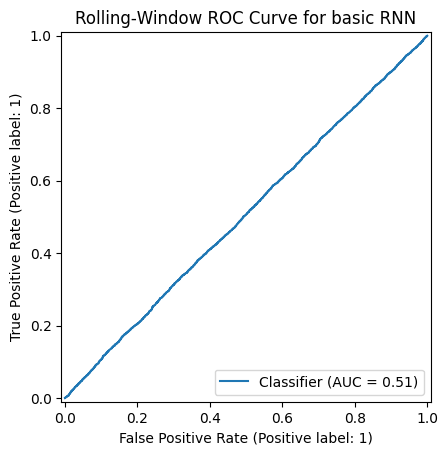

In [12]:
acc = accuracy_score(y_test_seq, y_pred)
f1  = f1_score(y_test_seq, y_pred)
auc = roc_auc_score(y_test_seq, y_proba)
cm  = confusion_matrix(y_test_seq, y_pred)

print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(y_test_seq, y_proba)
plt.title('Rolling‑Window ROC Curve for basic RNN')
plt.show()

## Deeper RNN
Experiment with stacking more RNN layers (varied from 2-4). More recurrent layers can potentially better learn the temporal dependencies between the input features.

In [13]:
def build_deep_rnn(hp):
    model = Sequential()
    n_layers = hp.Int('n_layers', 2, 4)
    for i in range(n_layers):
        units = hp.Int(f'units_{i}', 32, 256, step=32)
        return_seq = (i < n_layers-1)
        if i == 0:
            model.add(SimpleRNN(units,
                                return_sequences=return_seq,
                                input_shape=(rolling_window, len(features))))
        else:
            model.add(SimpleRNN(units, return_sequences=return_seq))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

class DeepBacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = build_deep_rnn(hp)
        year_accs = []

        for idx, year in enumerate(unique_years):
            if idx == 0:
                year_train = train_df
            else:
                cutoff = test_df[test_df['Year']==year]['Date'].min()
                up_to  = df[df['Date'] < cutoff]
                size   = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values
            year_test = test_df[test_df['Year']==year]
            X_te_s = scaler.transform(year_test[features])
            y_te   = year_test['target'].values

            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if len(X_tr_seq)==0 or len(X_te_seq)==0:
                continue

            model.fit(
                X_tr_seq, y_tr_seq,
                epochs=5, batch_size=32,
                verbose=1
            )

            preds = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            year_accs.append(accuracy_score(y_te_seq, preds))

        mean_acc = np.mean(year_accs) if year_accs else 0.0
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

tuner = DeepBacktestTuner(
    hypermodel=build_deep_rnn,
    objective=kt.Objective('val_accuracy','max'),
    max_trials=10,
    directory='rnn_backtest_tuner',
    project_name='deep_rnn_search'
)
tuner.search()


Trial 10 Complete [00h 01m 54s]
val_accuracy: 0.5048271797893874

Best val_accuracy So Far: 0.5173547234107971
Total elapsed time: 00h 14m 44s


### Evaluation
Get best model from tuner & retrain that model.

In [14]:
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)
best_model = build_deep_rnn(best_hp)

dev_df       = pd.concat([train_df, val_df], ignore_index=True)
scaler_dev   = StandardScaler().fit(dev_df[features])
X_dev_s      = scaler_dev.transform(dev_df[features])
y_dev        = dev_df['target'].values
X_dev_seq, y_dev_seq = create_sequences(X_dev_s, y_dev, rolling_window)

best_model.fit(
    X_dev_seq, y_dev_seq,
    epochs=5,          # same as in your tuner
    batch_size=32,
    verbose=1
)

X_test_s      = scaler_dev.transform(test_df[features])
y_test        = test_df['target'].values
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test, rolling_window)

y_proba = best_model.predict(X_test_seq).ravel()
y_pred  = (y_proba > 0.5).astype(int)

{'n_layers': 4, 'units_0': 96, 'dropout_0': 0.2, 'units_1': 192, 'dropout_1': 0.2, 'lr': 0.01, 'units_2': 32, 'dropout_2': 0.1, 'units_3': 192, 'dropout_3': 0.1}
Epoch 1/5


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.5006 - loss: 0.7346
Epoch 2/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5066 - loss: 0.7208
Epoch 3/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.4997 - loss: 0.7246
Epoch 4/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5053 - loss: 0.7296
Epoch 5/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5064 - loss: 0.7298
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step



Rolling‑Window RNN Results:
Accuracy: 0.5017
F1 Score:  0.5655
AUC‑ROC:   0.4992

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            2674          4613
Actual Up              2902          4891


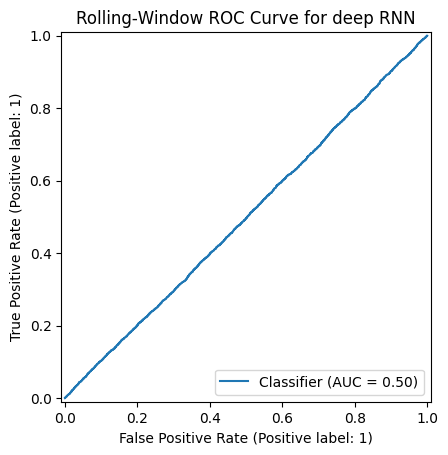

In [15]:
acc = accuracy_score(y_test_seq, y_pred)
f1  = f1_score(y_test_seq, y_pred)
auc = roc_auc_score(y_test_seq, y_proba)
cm  = confusion_matrix(y_test_seq, y_pred)

print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(y_test_seq, y_proba)
plt.title('Rolling‑Window ROC Curve for deep RNN')
plt.show()

## RNN with more Dense Layers
Attempt to add more dense layers after RNN layers to learn/represent more complex decision boundaries over the vector space before we squash it via sigmoid and output the final classification.

In [16]:
def build_rnn_with_dense(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Int('rnn_units', 32, 256, step=32),
        input_shape=(rolling_window, len(features))
    ))
    model.add(Dropout(hp.Float('dropout_rnn', 0.0, 0.5, step=0.1)))
    n_dense = hp.Int('n_dense', 1, 3)
    for i in range(n_dense):
        model.add(Dense(
            units=hp.Int(f'dense_units_{i}', 16, 128, step=16),
            activation=hp.Choice(f'dense_act_{i}', ['relu','tanh'])
        ))
        model.add(Dropout(hp.Float(f'dropout_dense_{i}', 0.0, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

class DenseBacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = build_rnn_with_dense(hp)
        accs = []

        for idx, year in enumerate(unique_years):
            if idx == 0:
                year_train = train_df
            else:
                cutoff     = test_df[test_df['Year']==year]['Date'].min()
                up_to      = df[df['Date'] < cutoff]
                size       = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values
            year_test = test_df[test_df['Year']==year]
            X_te_s    = scaler.transform(year_test[features])
            y_te      = year_test['target'].values

            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if len(X_tr_seq)==0 or len(X_te_seq)==0:
                continue

            model.fit(X_tr_seq, y_tr_seq, epochs=5, batch_size=32, verbose=1)
            preds = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            accs.append(accuracy_score(y_te_seq, preds))

        mean_acc = np.mean(accs) if accs else 0.0
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

tuner = DenseBacktestTuner(
    hypermodel=build_rnn_with_dense,
    objective=kt.Objective('val_accuracy','max'),
    max_trials=12,
    directory='dense_backtest_tuner',
    project_name='rnn_dense_search'
)
tuner.search()

Trial 12 Complete [00h 00m 16s]
val_accuracy: 0.5058352443055164

Best val_accuracy So Far: 0.5081690858079889
Total elapsed time: 00h 04m 53s


### Evaluation

In [17]:
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)
best_model = build_rnn_with_dense(best_hp)

dev_df       = pd.concat([train_df, val_df], ignore_index=True)
scaler_dev   = StandardScaler().fit(dev_df[features])
X_dev_s      = scaler_dev.transform(dev_df[features])
y_dev        = dev_df['target'].values
X_dev_seq, y_dev_seq = create_sequences(X_dev_s, y_dev, rolling_window)

best_model.fit(
    X_dev_seq, y_dev_seq,
    epochs=5,       
    batch_size=32,
    verbose=1
)

X_test_s      = scaler_dev.transform(test_df[features])
y_test        = test_df['target'].values
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test, rolling_window)

y_proba = best_model.predict(X_test_seq).ravel()
y_pred  = (y_proba > 0.5).astype(int)

{'rnn_units': 32, 'dropout_rnn': 0.30000000000000004, 'n_dense': 1, 'dense_units_0': 80, 'dense_act_0': 'tanh', 'dropout_dense_0': 0.2, 'lr': 0.0001, 'dense_units_1': 16, 'dense_act_1': 'relu', 'dropout_dense_1': 0.2, 'dense_units_2': 32, 'dense_act_2': 'tanh', 'dropout_dense_2': 0.0}
Epoch 1/5


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5080 - loss: 0.7028
Epoch 2/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5011 - loss: 0.6987
Epoch 3/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5044 - loss: 0.6977
Epoch 4/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5048 - loss: 0.6964
Epoch 5/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5138 - loss: 0.6944
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step



Rolling‑Window RNN Results:
Accuracy: 0.5165
F1 Score:  0.6706
AUC‑ROC:   0.5098

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down             369          6918
Actual Up               373          7420


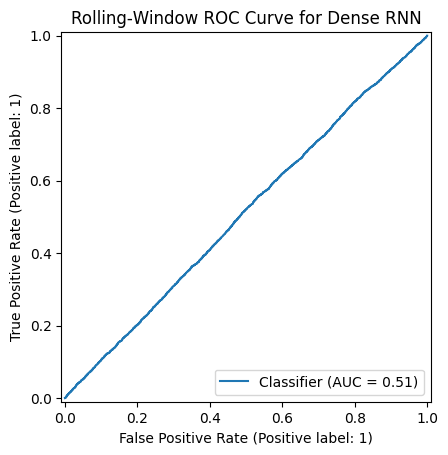

In [18]:

acc = accuracy_score(y_test_seq, y_pred)
f1  = f1_score(y_test_seq, y_pred)
auc = roc_auc_score(y_test_seq, y_proba)
cm  = confusion_matrix(y_test_seq, y_pred)

print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(y_test_seq, y_proba)
plt.title('Rolling‑Window ROC Curve for Dense RNN')
plt.show()

## RNN with Normalization
Normalizes all elements in hidden-state vectors across its features before activation function. Helps prevents neurons from drifting too far into the extremes of the activation function, helping to reduce vanishing/exploding gradient issues.

In [19]:
def build_rnn_with_norm(hp):
    model = Sequential()
    # -- single RNN layer --
    model.add(SimpleRNN(
        units=hp.Int('rnn_units', 32, 256, step=32),
        input_shape=(rolling_window, len(features))
    ))
    model.add(Dropout(hp.Float('dropout_rnn', 0.0, 0.5, step=0.1)))
    model.add(LayerNormalization())

    # -- tunable dense layers on top --
    n_dense = hp.Int('n_dense', 1, 3)
    for i in range(n_dense):
        model.add(Dense(
            units=hp.Int(f'dense_units_{i}', 16, 128, step=16),
            activation=hp.Choice(f'dense_act_{i}', ['relu','tanh'])
        ))
        model.add(Dropout(hp.Float(f'dropout_dense_{i}', 0.0, 0.5, step=0.1)))

    # -- output layer --
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# ── 2) Custom backtest tuner ──
class NormBacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = build_rnn_with_norm(hp)
        year_accs = []

        for idx, year in enumerate(unique_years):
            # select train slice
            if idx == 0:
                year_train = train_df
            else:
                cutoff     = test_df[test_df['Year']==year]['Date'].min()
                up_to      = df[df['Date'] < cutoff]
                size       = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            # scale
            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values

            year_test = test_df[test_df['Year']==year]
            X_te_s = scaler.transform(year_test[features])
            y_te   = year_test['target'].values

            # sequences
            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if len(X_tr_seq)==0 or len(X_te_seq)==0:
                continue

            # train quietly
            model.fit(
                X_tr_seq, y_tr_seq,
                epochs=10, batch_size=32,
                verbose=1
            )

            # evaluate this year
            preds = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            year_accs.append(accuracy_score(y_te_seq, preds))

        mean_acc = np.mean(year_accs) if year_accs else 0.0
        # report mean accuracy over years
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

# ── 3) Run the tuner ──
tuner = NormBacktestTuner(
    hypermodel=build_rnn_with_norm,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=12,
    directory='norm_backtest_tuner',
    project_name='rnn_norm_search'
)
tuner.search()

Trial 12 Complete [00h 00m 56s]
val_accuracy: 0.5073137923082836

Best val_accuracy So Far: 0.5073137923082836
Total elapsed time: 00h 13m 44s


### Evaluation

In [20]:
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)
best_model = build_rnn_with_norm(best_hp)

dev_df       = pd.concat([train_df, val_df], ignore_index=True)
scaler_dev   = StandardScaler().fit(dev_df[features])
X_dev_s      = scaler_dev.transform(dev_df[features])
y_dev        = dev_df['target'].values
X_dev_seq, y_dev_seq = create_sequences(X_dev_s, y_dev, rolling_window)

best_model.fit(
    X_dev_seq, y_dev_seq,
    epochs=5,       
    batch_size=32,
    verbose=1
)

X_test_s      = scaler_dev.transform(test_df[features])
y_test        = test_df['target'].values
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test, rolling_window)

y_proba = best_model.predict(X_test_seq).ravel()
y_pred  = (y_proba > 0.5).astype(int)

{'rnn_units': 160, 'dropout_rnn': 0.4, 'n_dense': 1, 'dense_units_0': 48, 'dense_act_0': 'tanh', 'dropout_dense_0': 0.2, 'lr': 0.0001, 'dense_units_1': 112, 'dense_act_1': 'relu', 'dropout_dense_1': 0.30000000000000004, 'dense_units_2': 48, 'dense_act_2': 'relu', 'dropout_dense_2': 0.0}
Epoch 1/5


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4993 - loss: 0.7534
Epoch 2/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4998 - loss: 0.7246
Epoch 3/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5042 - loss: 0.7151
Epoch 4/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5000 - loss: 0.7076
Epoch 5/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5048 - loss: 0.7040
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step



Rolling‑Window RNN Results:
Accuracy: 0.5001
F1 Score:  0.5190
AUC‑ROC:   0.4983

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            3476          3811
Actual Up              3727          4066


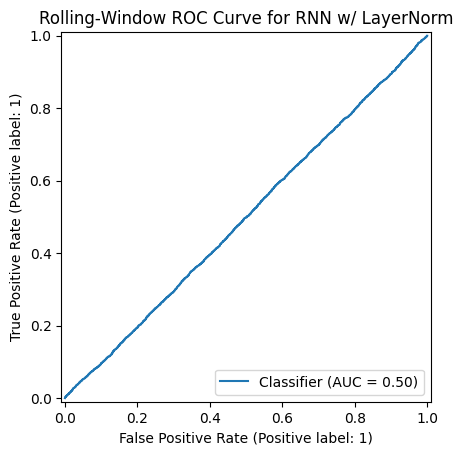

In [21]:
acc = accuracy_score(y_test_seq, y_pred)
f1  = f1_score(y_test_seq, y_pred)
auc = roc_auc_score(y_test_seq, y_proba)
cm  = confusion_matrix(y_test_seq, y_pred)

print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(y_test_seq, y_proba)
plt.title('Rolling‑Window ROC Curve for RNN w/ LayerNorm')
plt.show()

## RNN with gradient clipping
Attempt to deal with exploding gradients during backpropagation (if any). Improves stability when training with larger learning rates.

In [22]:
def build_clip_rnn(hp):
    model = Sequential([
        SimpleRNN(
            units=hp.Int('units', 32, 256, step=32),
            input_shape=(rolling_window, len(features))
        ),
        Dense(1, activation='sigmoid'),
    ])
    lr = hp.Choice('lr', [5e-1, 1e-1, 1e-2, 1e-3, 1e-4])
    clipnorm = hp.Float('clipnorm', 0.0, 2.0, step=0.5)
    if clipnorm > 0:
        optimizer = Adam(learning_rate=lr, clipnorm=clipnorm)
    else:
        optimizer = Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# ── 4) Custom backtest tuner (per‑year rolling backtest) ──
class ClipBacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp    = trial.hyperparameters
        model = build_clip_rnn(hp)
        accs  = []

        for idx, year in enumerate(unique_years):
            # build year_train
            if idx == 0:
                year_train = train_df
            else:
                cutoff     = test_df[test_df['Year']==year]['Date'].min()
                up_to      = df[df['Date'] < cutoff]
                size       = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            # scale features
            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values

            year_test = test_df[test_df['Year']==year]
            X_te_s    = scaler.transform(year_test[features])
            y_te      = year_test['target'].values

            # create sequences
            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if not len(X_tr_seq) or not len(X_te_seq):
                continue

            # train & evaluate quietly
            model.fit(
                X_tr_seq, y_tr_seq,
                epochs=5, batch_size=32,
                verbose=1
            )
            preds = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            accs.append(accuracy_score(y_te_seq, preds))

        mean_acc = np.mean(accs) if accs else 0.0
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

# ── 5) Run the tuner ──
tuner = ClipBacktestTuner(
    hypermodel=build_clip_rnn,
    objective=kt.Objective('val_accuracy','max'),
    max_trials=10,
    directory='clip_rnn_tuner',
    project_name='clip_backtest'
)
tuner.search()

Trial 10 Complete [00h 00m 21s]
val_accuracy: 0.5034311025135155

Best val_accuracy So Far: 0.5201497604345486
Total elapsed time: 00h 04m 21s


### Evaluation

In [23]:
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)
best_model = build_clip_rnn(best_hp)

dev_df       = pd.concat([train_df, val_df], ignore_index=True)
scaler_dev   = StandardScaler().fit(dev_df[features])
X_dev_s      = scaler_dev.transform(dev_df[features])
y_dev        = dev_df['target'].values
X_dev_seq, y_dev_seq = create_sequences(X_dev_s, y_dev, rolling_window)

best_model.fit(
    X_dev_seq, y_dev_seq,
    epochs=5,       
    batch_size=32,
    verbose=1
)

X_test_s      = scaler_dev.transform(test_df[features])
y_test        = test_df['target'].values
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test, rolling_window)

y_proba = best_model.predict(X_test_seq).ravel()
y_pred  = (y_proba > 0.5).astype(int)

{'units': 192, 'lr': 0.1, 'clipnorm': 1.5}
Epoch 1/5


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4983 - loss: 1.0837
Epoch 2/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4975 - loss: 1.2144
Epoch 3/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4974 - loss: 1.3663
Epoch 4/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4924 - loss: 1.2027
Epoch 5/5
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4978 - loss: 1.4825
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step



Rolling‑Window RNN Results:
Accuracy: 0.5168
F1 Score:  0.6814
AUC‑ROC:   0.5012

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down               0          7287
Actual Up                 0          7793


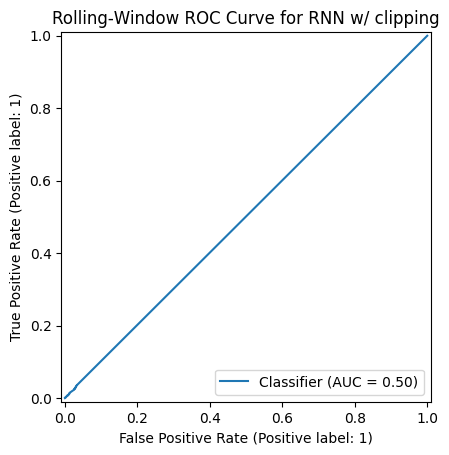

In [24]:
acc = accuracy_score(y_test_seq, y_pred)
f1  = f1_score(y_test_seq, y_pred)
auc = roc_auc_score(y_test_seq, y_proba)
cm  = confusion_matrix(y_test_seq, y_pred)

print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")
print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(y_test_seq, y_proba)
plt.title('Rolling‑Window ROC Curve for RNN w/ clipping')
plt.show()